<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/GSE145926_GSM4475051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSE145926_GSM4475051

This dataset was too large to be processed in google colab. The gene count and TCC were generated using the following commands:

```
SRA=SRR11537949
GSM=GSM4475051

cd /central/scratch/agalvezm/ace2/counts

/central/home/agalvezm/opt/sratoolkit.2.10.9-centos_linux64/bin/prefetch 2.10.9 ${SRA} --max-size 2000000000

cd ${SRA}

/central/home/agalvezm/opt/sratoolkit.2.10.9-centos_linux64/bin/fasterq-dump --split-files --outdir fastq --include-technical ${SRA}.sra

~/anaconda3/bin/kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta

~/anaconda3/bin/kb count --h5ad -i index.idx -g t2g.txt -x 10xv2 -o ../results/output${GSM} --filter bustools -t 2 ${SRA}_1.fastq.gz ${SRA}_2.fastq.gz

~/anaconda3/bin/kb count --h5ad -i index.idx -g t2g.txt -x 10xv2 -o ../results/tccoutput${GSM} --tcc --filter bustools -t 2 ${SRA}_1.fastq.gz ${SRA}_2.fastq.gz

```






In [1]:
no_samples = 1

fastqs_per_sample = [1] 

sample_id = "GSE145926"

database_id = ["GSM4475051"] * no_samples

tissue = ["lung"] * no_samples

cell_type = ["bronchoalveolar lavage fluid cells"] * no_samples

condition = ["covid-infected, severe, total cells"] * no_samples

species = ["human"] * no_samples

technology = ["10xv2"] * no_samples

paper = ["Liao et al. Nature medicine (2020)"] * no_samples

figure = ["Fig 1"] * no_samples

# Set string variables for kb functions

species_kb = species[0]

technology_kb = technology[0]

# Imports and installs

In [2]:
# install and import necessary software

# Install kb and scanpy
!pip -q install kb-python 
!pip -q install scanpy

import re
import os

# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

     |████████████████████████████████| 59.1MB 63kB/s 
     |████████████████████████████████| 133kB 33.7MB/s 
     |████████████████████████████████| 13.2MB 46.9MB/s 
     |████████████████████████████████| 10.3MB 17.5MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 112kB 45.5MB/s 
     |████████████████████████████████| 1.2MB 53.3MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 


In [3]:
# Execute kb ref to get t2g.txt file
!kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta


[2021-05-07 05:20:06,799]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
100% 2.23G/2.23G [02:54<00:00, 13.7MB/s]
[2021-05-07 05:23:03,171]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


# Load unfiltered matrix and assign filters to each matrix individually

## Load the unfiltered matrices

In [15]:
# # # Gunzip matrices
# !gunzip /content/adata.h5ad.gz
# !gunzip /content/adata_tcc.h5ad.gz

# Load matrices
adata = anndata.read_h5ad("/content/adata.h5ad")
adata_tcc = anndata.read_h5ad("/content/adata_tcc.h5ad")

In [16]:
adata.var

,gene_name
gene_id,
ENSG00000223972.5,DDX11L1
ENSG00000227232.5,WASH7P
ENSG00000278267.1,MIR6859-1
ENSG00000243485.5,MIR1302-2HG
ENSG00000284332.1,MIR1302-2
...,...
ENSG00000271254.6,AC240274.1
ENSG00000275405.1,U1
ENSG00000275987.1,U1


In [17]:
# Reformat and fill gene count matrix 

adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]
print("The unfiltered matrix " + sample_id + " contains {} cells by {} genes".format(len(adata.obs), len(adata.var)))

adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith("MT-" or "mt-") 
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

# Changing the name of the index is necessary to write the file (it won't work with duplicated names)
adata.var.index.name = "index"



The unfiltered matrix GSE145926 contains 314346 cells by 60623 genes


## Assign filters for gene count matrix

In [18]:
results = {}


# Filtering criteria
cell_threshold = 100
gene_threshold = 3


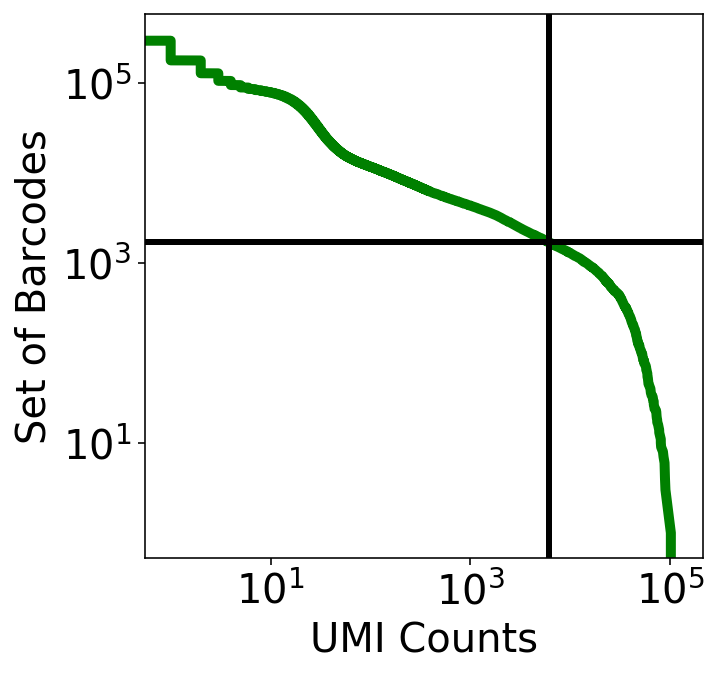

Cells were filtered down to 1700 with at least 6128.0 UMIs


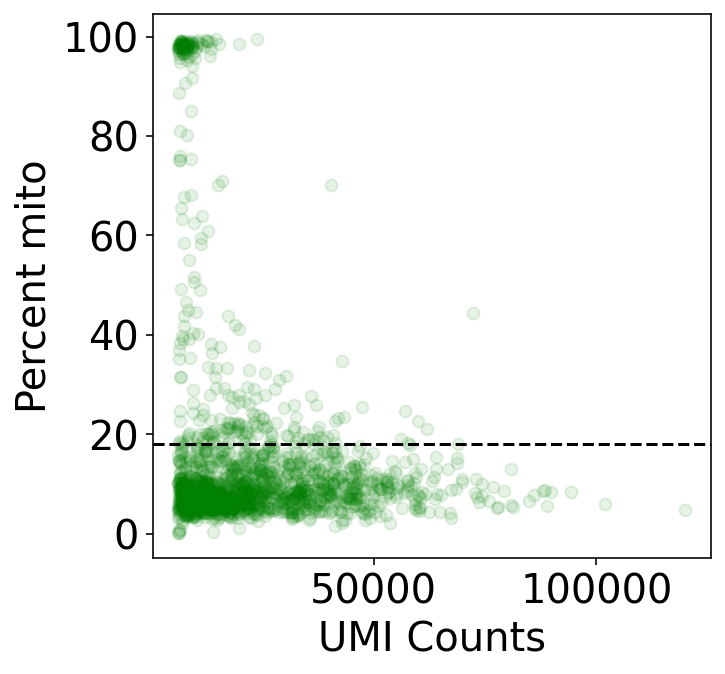

We select 18 % as the mitochondrial content threshold


In [19]:
expected_num_cells = 1700#@param {type:"integer"}
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

cell_threshold = knee[expected_num_cells]

results["cell_threshold" + sample_id] = knee[expected_num_cells]

print ("Cells were filtered down to " + str(expected_num_cells) + " with at least " + str(cell_threshold) + " UMIs")


mito_criteria = 18#@param {type:"integer"}
results["mito_criteria" + sample_id] = mito_criteria

fig, ax = plt.subplots(figsize=(5,5))


x = nd(adata.obs["cell_counts"][adata.obs["cell_counts"] > cell_threshold])
y = nd(adata.obs["percent_mito"][adata.obs["cell_counts"] > cell_threshold])

ax.scatter(x, y, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")


plt.show()

print("We select " + str(mito_criteria) + " % as the mitochondrial content threshold")


# Filter gene count matrix

In [20]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > results["cell_threshold" + sample_id]
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < results["mito_criteria" + sample_id]
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))
results["data_" + sample_id] = adata[cell_mask, gene_mask]


Current Shape: 314,346 cells x 60,623 genes
    New shape: 1,427 cells x 29,144 genes


# Anotate and write gene count matrix

In [23]:
adata.uns["database_id"] = sample_id

adata.uns["tissue"] = tissue[0]

adata.uns["cell_type"] = cell_type[0]

adata.uns["sample_id"] = database_id[0]

adata.uns["condition"] = condition[0]

adata.uns["species"] = species[0]

adata.uns["technology"] = technology[0]

adata.uns["paper"] = paper[0]

adata.uns["figure"] = figure[0]

%cd /content

adata.write("result" + database_id[0])

/content


In [24]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('database_id', 'GSE145926'), ('tissue', 'lung'), ('cell_type', 'bronchoalveolar lavage fluid cells'), ('sample_id', 'GSM4475051'), ('condition', 'covid-infected, severe, total cells'), ('species', 'human'), ('technology', '10xv2'), ('paper', 'Liao et al. Nature medicine (2020)'), ('figure', 'Fig 1')])
With overloaded keys:
	['neighbors'].

Filter TCC using gene count matrix's filter

In [25]:
adata_tcc = adata_tcc[adata.obs.index.values]
# transfer obs data
adata_tcc.obs = adata.obs
# transfer metadata
adata_tcc.uns = adata.uns
# write tcc matrix
adata_tcc.write("/content/tcc_" + database_id[0])
#gzip tcc matrix
cmd = "gzip /content/tcc_" + database_id[0]
!$cmd